This is the code that resulted in the final results in the first assignment of the masters class Machine Learning for economic analysis. The procedure is as follows:<br>
    1) First the data is loaded and prepared such that it is cleaned and ready for further analysis (for the precise data preparation I refer to the data preprocessing file)<br>
    2) Some first data exploration and a decision tree is calculated to get an idea of the random forest approach<br>
    3) The heart of this file. The development of the optimal random forest model. The procedure is as follows: Starting at deciding which subset of predictors to take (p, p/2, sqrt(p)). Having derived the subset of predictors, the next parameter under analysis is k, the number of trees in the forest. We then take the optimal parameters on the basis of the MSE and the OOB score. We then estimate the MSE of the entire training set (22'674 observations) and check for overfitting. <br>
    4) Having decided on the optimal random forest model, the next step is to estimate the model and see how it works on the full sample that is provided. The final MSE is calculated.

__1)__

In [1]:
#Loading packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import matplotlib.lines as mlines
import statsmodels.api as sm

# Load packages
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import datasets
from stargazer.stargazer import Stargazer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from six import StringIO  
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error

In [2]:
# Set global parameters for figures
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

In [4]:
# Read in the data
data = pd.read_csv('https://raw.githubusercontent.com/SophiaBieri/MLfEA-Project-1/main/data_preprocessed.csv?token=AR22ANL3SNGHEA3ZNQVIVKK72SNF6')
# Get the shape of the data
data.shape

(22674, 65)

In [5]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None
display(data.head())

,lnpercapitaconsumption,d_fuel_wood,d_fuel_coal,d_fuel_kerosene,d_fuel_gas,d_fuel_electric,d_fuel_none,d_water_river,d_water_well,d_water_truck,d_water_pylon,d_water_outside,d_water_inside,d_drain_none,d_drain_river,d_drain_cesspool,d_drain_septic,d_drain_outside,d_drain_inside,d_wall_woodmat,d_wall_stonemud,d_wall_quincha,d_wall_tapia,d_wall_adobe,d_wall_stonecement,d_wall_brickcement,d_roof_straw,d_roof_mat,d_roof_platecane,d_roof_tile,d_roof_wood,d_roof_concrete,d_floor_earth,d_floor_cement,d_floor_wood,d_floor_tile,d_floor_sheets,d_floor_parquet,d_electricity,d_telephone,d_h_educ_none,d_h_educ_pre,d_h_educ_prim,d_h_educ_sec,d_h_educ_higher_nouni,d_h_educ_higher_uni,d_h_educ_post,d_max_educ_none,d_max_educ_prim,d_max_educ_sec,d_max_educ_higher_nouni,d_max_educ_higher_uni,d_insurance_1,d_insurance_2,d_insurance_3,d_insurance_4plus,d_crowd_1to2,d_crowd_2to4,d_crowd_4to6,d_crowd_6plus,d_lux_1,d_lux_2,d_lux_3,d_lux_4,d_lux_5
0,5.304770,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0
1,7.179197,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,1,0,0,1,0,1.0,0.0,0.0,0.0,0,0,0,1,0
2,5.546008,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,1,0,0,0.0,1.0,0.0,0.0,0,0,0,0,0
3,5.321395,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,1,1.0,0.0,0.0,0.0,0,0,0,0,0
4,5.347988,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,1.0,0.0,0.0,0.0,0,0,0,0,0


__2)__ To get started, let us first build one tree and get a sense of how the intuition works

In [6]:
# Get the data for the dependent variable
y = data['lnpercapitaconsumption']
# Get the data for the explanatory variables
X = data.drop(['lnpercapitaconsumption'], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)

dlf = DecisionTreeRegressor(max_depth=2, min_samples_split = 7, max_features= 21, min_samples_leaf = 2, 
                            splitter = 'random', random_state=1)
dlf.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=2, max_features=21, min_samples_leaf=2,
                      min_samples_split=7, random_state=1, splitter='random')

In [7]:
pred = dlf.predict(X_test)
mean_squared_error(y_test, pred)

0.32301667558651054

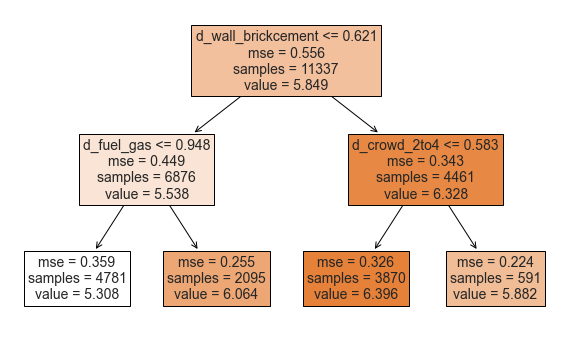

In [8]:
dt_feature_names = list(X.columns)
# Figure 8.1
fig, ax = plt.subplots(1,1)
ax.set_title('Sample Tree');

# Plot tree
plot_tree(dlf, filled=True, feature_names=dt_feature_names, fontsize=14, ax=ax);

__3)__ Let us now consider the impact of different numbers of parameters that are allowed in one tree. 

In [9]:
# Init
params = range(3,400,5)
m_scores = np.zeros((len(params),3))
p = np.shape(X)[1]
J = 5;

# Loop over parameters
for i, k in enumerate(params):
    
    # Array of features
    ms = [p, round(p/2), round(p**.5)]
    
    # Repeat L times
    temp_scores = np.zeros((J,3))
    for j in range(J):
        print("Computing k=%1.0f (iter=%1.0f)" % (k,j+1), end ="")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, random_state=j)
    
        # Loop over values of m
        for l, m in enumerate(ms):
            forest = RandomForestRegressor(n_estimators=k, max_features=m)
            forest.fit(X_train, y_train)
            temp_scores[j,l] = forest.score(X_test, y_test)
        print("", end="\r")
            
    # Average
    m_scores[i,:] = np.mean(temp_scores, axis=0)

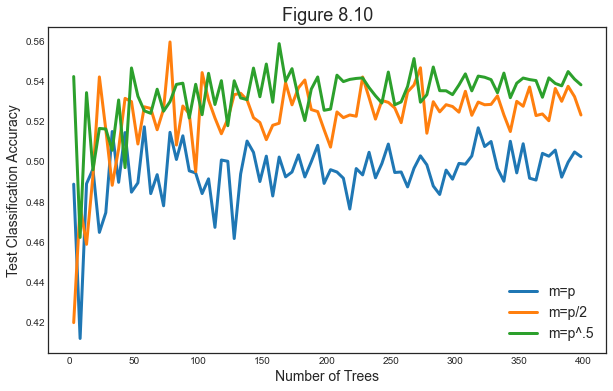

In [10]:
# Figure 8.10
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('Figure 8.10');

# Plot scores
ax.plot(params, m_scores);
ax.legend(['m=p','m=p/2','m=p^.5']);
ax.set_xlabel('Number of Trees'); ax.set_ylabel('Test Classification Accuracy');

What is easy to see, is that m=p is always outperformed by m=sqrt(p). m=p/2 and m=sqrt(p) are both close to each other, however, it seems that m=sqrt(p) performs a little better overall. Hence, we will use m=sqrt(p)

Impact of the number of trees for m=sqrt(p)

In [92]:
import warnings
warnings.simplefilter('ignore')

# Init
params = range(2,400,5)
forest_scores = np.zeros((len(params),2))
J = 5

# Loop over parameters
for i, k in enumerate(params):
    
    # Repeat J 
    temp_scores = np.zeros((J,2))
    for j in range(J):
        print("Computing k=%1.0f (iter=%1.0f)" % (k,j+1), end ="")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=j)
        forest = RandomForestRegressor(n_estimators=k, oob_score=True, max_features="sqrt")
        m = forest.fit(X_train,y_train)
        #temp_scores[j,0] = -forest.score(X_test, y_test)
        temp_scores[j,0] = mean_squared_error(m.predict(X_train), y_train)
        temp_scores[j,1] = forest.oob_score_
        print("", end="\r")
        
    # Average
    forest_scores[i,:] = np.mean(temp_scores, axis=0)

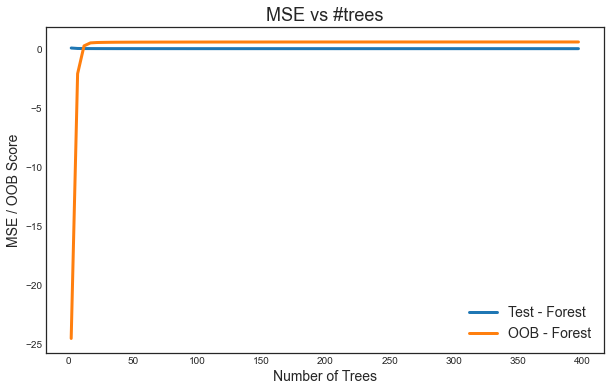

In [107]:
# Figure
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('MSE vs #trees');

# Plot scores
ax.plot(params, forest_scores);
ax.legend(['Test - Forest','OOB - Forest']);
ax.set_xlabel('Number of Trees'); ax.set_ylabel('MSE / OOB Score');

In [24]:
forest_scores

array([[ 0.0688533 , -5.96815619],
       [ 0.0574223 , -0.07482999],
       [ 0.05464759,  0.48381564],
       [ 0.05222772,  0.56247291],
       [ 0.05105321,  0.57762175],
       [ 0.04992729,  0.58492172],
       [ 0.04970106,  0.59064759],
       [ 0.04909884,  0.59436223],
       [ 0.04884149,  0.59615651],
       [ 0.04869812,  0.59782226],
       [ 0.04836224,  0.60166002],
       [ 0.04823482,  0.60198438],
       [ 0.04805701,  0.6031288 ],
       [ 0.04808637,  0.60467747],
       [ 0.04793659,  0.60528146],
       [ 0.04761266,  0.60677482],
       [ 0.0476031 ,  0.6079189 ],
       [ 0.04756405,  0.60680788],
       [ 0.04754414,  0.60646425],
       [ 0.04757875,  0.60735594],
       [ 0.04746594,  0.60765953],
       [ 0.04730371,  0.61065403],
       [ 0.0472155 ,  0.61002006],
       [ 0.04728129,  0.61005711],
       [ 0.04722614,  0.61013287],
       [ 0.04728361,  0.61070385],
       [ 0.04719299,  0.61130267],
       [ 0.04715803,  0.61068612],
       [ 0.04713197,

Optimal n = 343 Results in lowest training MSE. One could potentially also increase n by some thousand to get even more precise estimates, but as there will only be limited improvement, we stick with the n = 343. Next step: calculate MSE

In [15]:
import warnings
warnings.simplefilter('ignore')

# Init
params = range(5,400,5)
forest_scores = np.zeros((len(params),2))
MSE_RF= np.zeros((len(params),1))
J = 3

# Loop over parameters
for i, k in enumerate(params):
    
    # Repeat J 
    temp_scores = np.zeros((J,2))
    temp_MSE_RF = np.zeros((J,1))
    for j in range(J):
        print("Computing k=%1.0f (iter=%1.0f)" % (k,j+1), end ="")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=j)
        forest = RandomForestRegressor(n_estimators=k, oob_score=True, max_features="sqrt")
        m = forest.fit(X_train,y_train)
        #temp_scores[j,0] = -forest.score(X_test, y_test)
        temp_scores[j,0] = mean_squared_error(m.predict(X_train), y_train)
        temp_scores[j,1] = forest.oob_score_
        m = forest.fit(X, y)
        temp_MSE_RF[j,0] = mean_squared_error(m.predict(X), y)
        
        print("", end="\r")
        
    # Average
    forest_scores[i,:] = np.mean(temp_scores, axis=0)
    MSE_RF[i,:] = np.mean(temp_MSE_RF, axis=0)

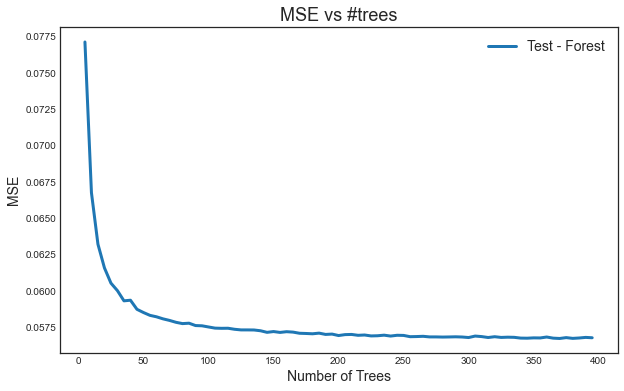

In [16]:
# Figure
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('MSE vs #trees');

# Plot scores
ax.plot(params, MSE_RF);
ax.legend(['Test - Forest','OOB - Forest']);
ax.set_xlabel('Number of Trees'); ax.set_ylabel('MSE');

In [20]:
MSE_RF

array([[0.07713828],
       [0.06677376],
       [0.06322581],
       [0.06159774],
       [0.0605493 ],
       [0.06003045],
       [0.05933276],
       [0.05937443],
       [0.05874932],
       [0.0585282 ],
       [0.05833325],
       [0.05823457],
       [0.05809352],
       [0.05798607],
       [0.05785563],
       [0.05776615],
       [0.05779388],
       [0.05763222],
       [0.05761519],
       [0.05753445],
       [0.05745544],
       [0.05744161],
       [0.057447  ],
       [0.05737581],
       [0.05733257],
       [0.05733193],
       [0.05732726],
       [0.05727377],
       [0.05716518],
       [0.05721933],
       [0.05715938],
       [0.05720958],
       [0.05718075],
       [0.05710172],
       [0.05708691],
       [0.05706607],
       [0.05711073],
       [0.05702179],
       [0.05704486],
       [0.05694497],
       [0.0570088 ],
       [0.05702053],
       [0.05696085],
       [0.05698208],
       [0.05691862],
       [0.0569308 ],
       [0.05697046],
       [0.056

Training MSE and OOB Score of the entire trainig set (22'674 observations)

In [108]:
import warnings
warnings.simplefilter('ignore')

forest = RandomForestRegressor(n_estimators=343, oob_score=True, max_features="sqrt")
m = forest.fit(X,y)
MSE = mean_squared_error(m.predict(X), y)
OOB = forest.oob_score_

In [109]:
MSE

0.056725887395141845

In [110]:
OOB

0.6158143855366635

Validation set MSE (check overfitting)

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
forest = RandomForestRegressor(n_estimators=343, oob_score=True, max_features="sqrt", )
m = forest.fit(X_train,y_train)
MSE = mean_squared_error(m.predict(X_test), y_test)
MSE

0.21577694179453846

__4)__ Now we turn to the full dataset to generate the predictions for the entire dataset:

In [66]:
# Read in the data
data_full = pd.read_csv('C:/Users/marco/Documents/Uni/HS_20/Machine Learning/Exercise/Assignment 1/data_preprocessed_full.csv')
# Get the shape of the data
data_full.shape

(45378, 70)

In [70]:
# Get the full data for the explanatory variables
X_full = data_full.drop(['training','id_for_matlab','hhid','lnpercapitaconsumption','lncaphat_OLS','percapitahat_OLS'], axis=1)
Y_full = data_full['lnpercapitaconsumption']

In [103]:
data_test = data_full[data_full['training'] == 0]

In [105]:
X_test2 = data_test.drop(['training','id_for_matlab','hhid','lnpercapitaconsumption','lncaphat_OLS','percapitahat_OLS','groupprediction_RF'], axis=1)
Y_test2 = data_test['lnpercapitaconsumption']

Calculate test MSE

In [113]:
forest = RandomForestRegressor(n_estimators=343, oob_score=True, max_features="sqrt", )
m = forest.fit(X,y)
MSE = mean_squared_error(m.predict(X_test2),Y_test2)
MSE

0.21155893419309252

Export to CSV file

In [ ]:
y_predictions_RF = m.predict(X_full)

In [ ]:
# Extract the CSV file as needed
data_full['groupprediction_RF'] = y_predictions_RF
RandomForestPredictions = data_full[['id_for_matlab','hhid','training','lnpercapitaconsumption','groupprediction_RF']]
RandomForestPredictions.to_csv(r'RF_predictions.csv', index = False, header=True)

Addtional: Calculate the MSE that results from the entire training set and create predictions for all (45K+) observations

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
forest = RandomForestRegressor(n_estimators=343, oob_score=True, max_features="sqrt", )
m = forest.fit(X,y)
MSE = mean_squared_error(m.predict(X_full),Y_full)
MSE

0.13421330786996988